In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Cat vs. Dog Image Classification
In this exercise, we will build a convolutional neural net from scratch that is able to distinguish dogs from cats. We will follow these steps:

1. Explore the example data
2. Build a small convnet to solve our classification problem
3. Evaluate training and validation accuracy
4. Use DataAugmentation to reduce overfitting
5. Add Dropout to further reduce overfitting


## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-06-03 17:37:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  19.1MB/s    in 4.5s    

2024-06-03 17:37:09 (14.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [4]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.528.jpg', 'cat.714.jpg', 'cat.656.jpg', 'cat.605.jpg', 'cat.669.jpg', 'cat.645.jpg', 'cat.776.jpg', 'cat.706.jpg', 'cat.901.jpg', 'cat.828.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

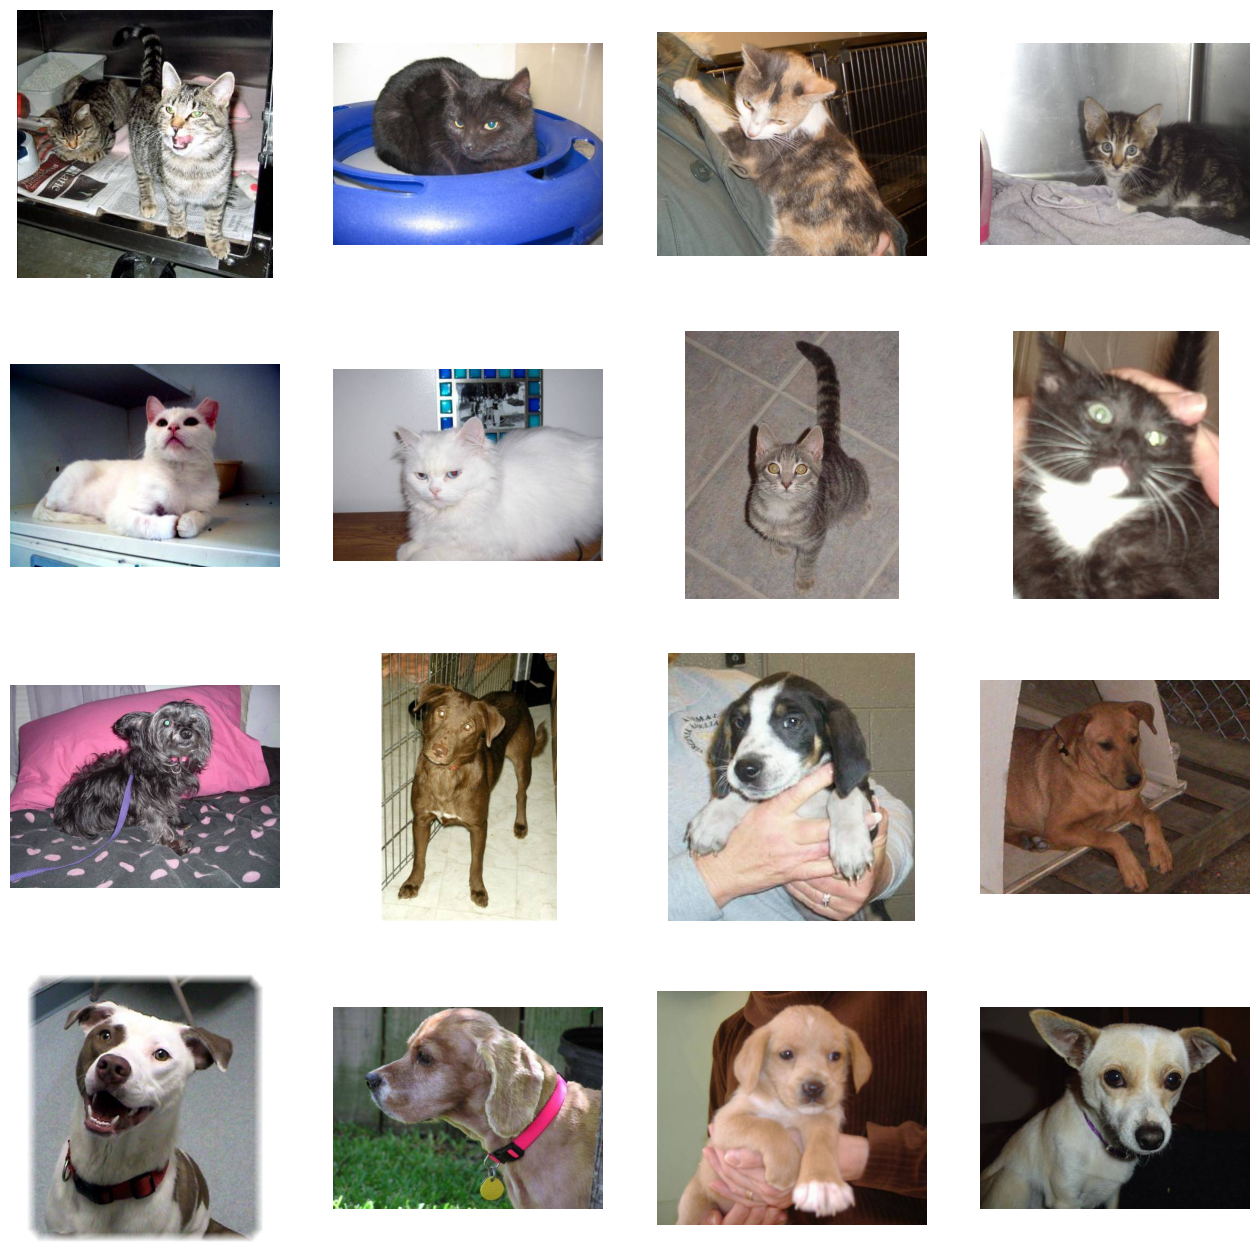

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [9]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


32
tf.Tensor(0, shape=(), dtype=int32)


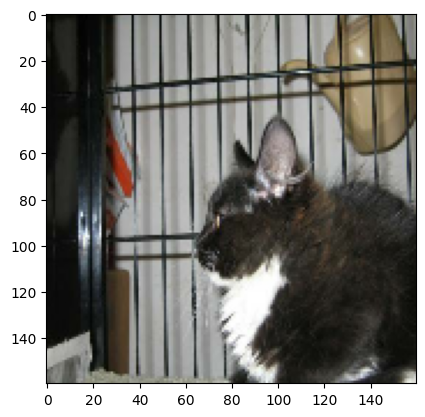

In [10]:
for element in train_dataset.take(1):
  #print(element)
  size_batch = element[0].shape[0]
  print(size_batch)
  image = element[0][0] # image of the first element of the 32 size batch
  label = element[1][0] # label of the first element of the 32 size batch
  print(label)
  image = image / 255.0
  plt.imshow(image)
  plt.show()

## Building a Small Convnet from Scratch

The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

**NOTE**: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model small, which lowers the risk of overfitting (which we'll explore in more depth in the second part of this notebook.)

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we could  end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). In that case the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0). But for the sake of generalitation to N classes, we will work with two output units and softmax.

In [11]:
IMG_SIZE_HEIGHT = 160
IMG_SIZE_WIDTH = 160

cnn = tf.keras.Sequential([
    # Our input feature map is 160x160x3: 160x160 for the image pixels, and 3 for
    # the three color channels: R, G, and B
    layers.Input(shape=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3,)),

    layers.Rescaling(1./255),

    # First convolution extracts 16 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2),

    # TODO 1: Create the second convolution layer followed by a MaxPooling2D layer
    # Second convolution extracts 32 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),

    # Third convolution extracts 64 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),

    # TODO 2: Flatten the output of the precedent layer
    # Flatten feature map to a 1-dim tensor so we can add fully connected layers

    layers.Flatten(),

    # TODO 3: Create the fully connected layer(dense)
    # Create a fully connected layer with ReLU activation and 512 hidden units

    layers.Dense(units=512, activation="relu"),

    # Create output layer with a single node and sigmoid activation
    layers.Dense(2, activation='softmax')
])

Let's summarize the model architecture:

In [12]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 64)        1

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, we'll configure the specifications for model training. We will train our model with `sparse_categorial_crossentropy` loss, as we use softmax and the labels are reprented as integers rather than one-hot vectors. We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [13]:
from tensorflow.keras.optimizers import RMSprop

cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

Let's now train the model to see how it's working!

In [14]:
history = cnn.fit(train_dataset, epochs=15, validation_data=validation_dataset, verbose=2)

Epoch 1/15
63/63 - 9s - loss: 0.7806 - acc: 0.5445 - val_loss: 0.6794 - val_acc: 0.5990 - 9s/epoch - 136ms/step
Epoch 2/15
63/63 - 3s - loss: 0.6581 - acc: 0.6245 - val_loss: 1.1130 - val_acc: 0.5060 - 3s/epoch - 54ms/step
Epoch 3/15
63/63 - 3s - loss: 0.6157 - acc: 0.6715 - val_loss: 0.6183 - val_acc: 0.6500 - 3s/epoch - 48ms/step
Epoch 4/15
63/63 - 3s - loss: 0.5455 - acc: 0.7250 - val_loss: 0.6080 - val_acc: 0.7020 - 3s/epoch - 47ms/step
Epoch 5/15
63/63 - 5s - loss: 0.5051 - acc: 0.7475 - val_loss: 0.5684 - val_acc: 0.7070 - 5s/epoch - 86ms/step
Epoch 6/15
63/63 - 3s - loss: 0.4447 - acc: 0.7865 - val_loss: 0.6728 - val_acc: 0.6770 - 3s/epoch - 54ms/step
Epoch 7/15
63/63 - 4s - loss: 0.3850 - acc: 0.8240 - val_loss: 0.7262 - val_acc: 0.6920 - 4s/epoch - 64ms/step
Epoch 8/15
63/63 - 3s - loss: 0.3385 - acc: 0.8555 - val_loss: 0.7100 - val_acc: 0.7080 - 3s/epoch - 47ms/step
Epoch 9/15
63/63 - 3s - loss: 0.2657 - acc: 0.8930 - val_loss: 0.6976 - val_acc: 0.6940 - 3s/epoch - 46ms/step


## Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

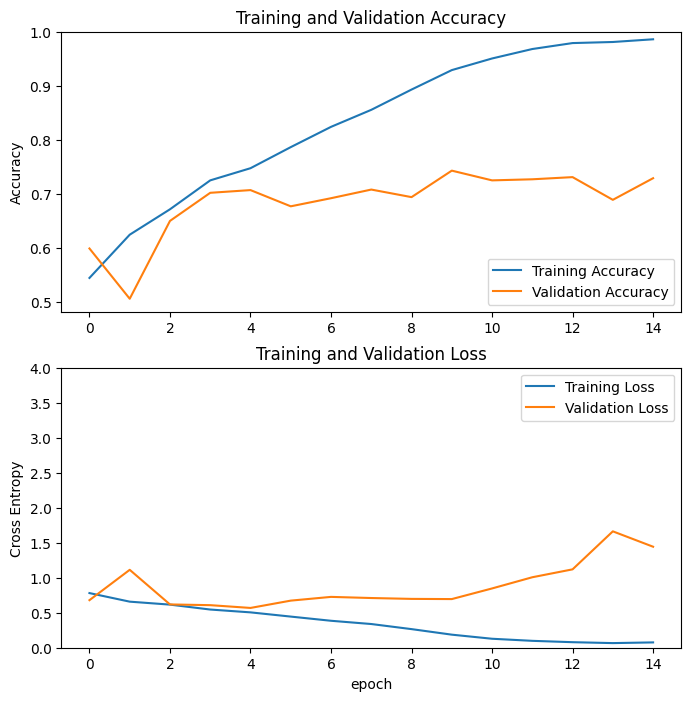

In [15]:

def plot_accuracy_and_loss(history):

  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,4.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

plot_accuracy_and_loss(history)


## Data Augmentation by using ImageDataGenerator

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 160x160 and their labels (sparse).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [16]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator()

# Flow training images in batches of 32 using train_datagen generator
# TODO 4 use flow_from_directory to generate a train_generator

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

# Flow validation images in batches of 32 using val_datagen generator
# TODO 5 use flow_from_directory to generate a validation_generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 validation images. (This may take a few minutes to run.)

In [17]:
# TODO 6 fit the model now using train_generator and validation_generator during 40 epochs
history = cnn.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator
)

Epoch 1/40
63/63 [==============================] - 18s 280ms/step - loss: 0.8892 - acc: 0.6310 - val_loss: 0.5706 - val_acc: 0.6970
Epoch 2/40
63/63 [==============================] - 17s 264ms/step - loss: 0.6165 - acc: 0.6645 - val_loss: 0.6011 - val_acc: 0.6920
Epoch 3/40
63/63 [==============================] - 18s 282ms/step - loss: 0.5813 - acc: 0.6990 - val_loss: 0.5475 - val_acc: 0.7520
Epoch 4/40
63/63 [==============================] - 18s 284ms/step - loss: 0.5872 - acc: 0.6930 - val_loss: 0.5282 - val_acc: 0.7640
Epoch 5/40
63/63 [==============================] - 18s 285ms/step - loss: 0.5859 - acc: 0.7050 - val_loss: 0.5066 - val_acc: 0.7660
Epoch 6/40
63/63 [==============================] - 16s 259ms/step - loss: 0.5489 - acc: 0.7190 - val_loss: 0.5185 - val_acc: 0.7530
Epoch 7/40
63/63 [==============================] - 17s 269ms/step - loss: 0.5655 - acc: 0.7185 - val_loss: 0.5645 - val_acc: 0.7190
Epoch 8/40
63/63 [==============================] - 17s 277ms/step - 

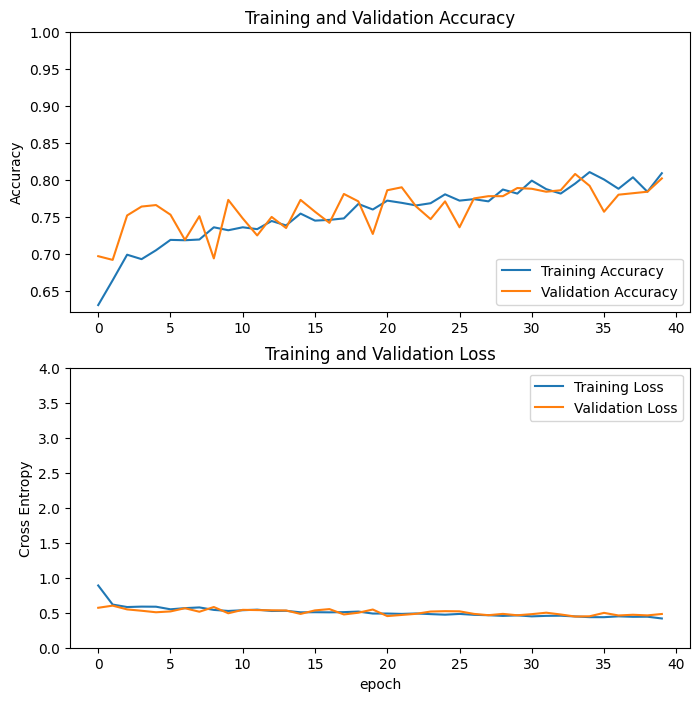

In [18]:
plot_accuracy_and_loss(history)

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

['rescaling', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'flatten', 'dense', 'dense_1']
1/1 [==============================] - 0s 321ms/step


<ipython-input-20-bdb3c5555a23>:46: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-20-bdb3c5555a23>:49: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


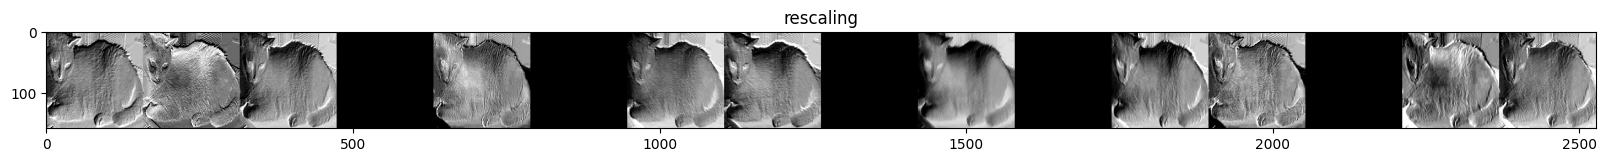

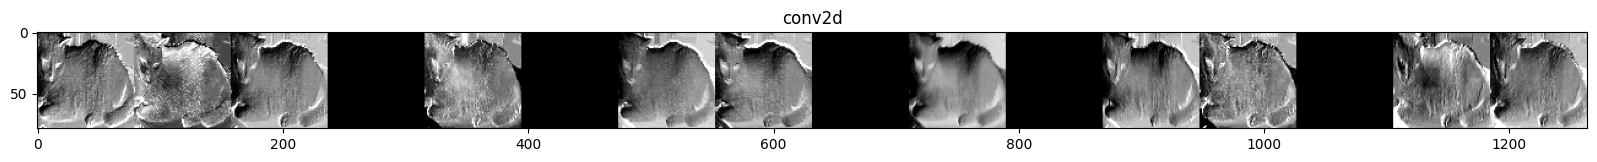

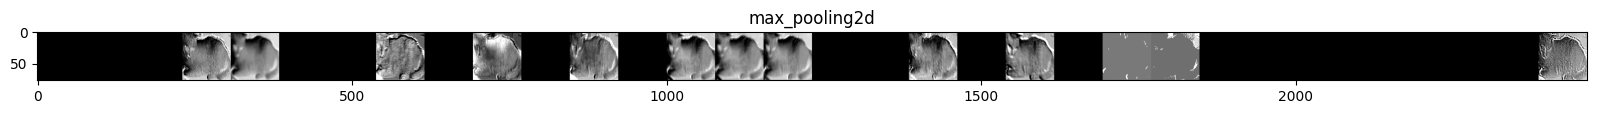

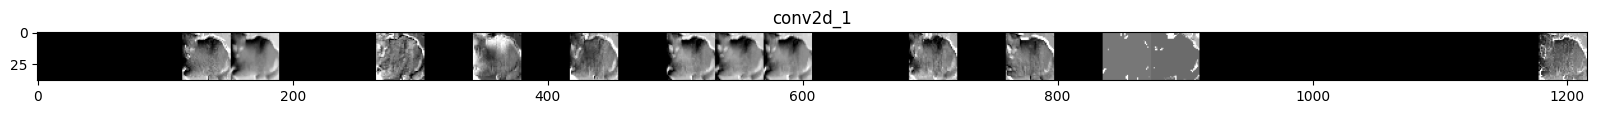

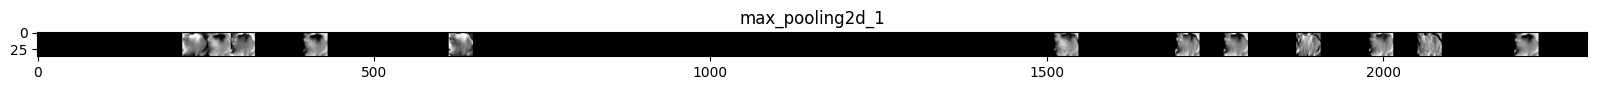

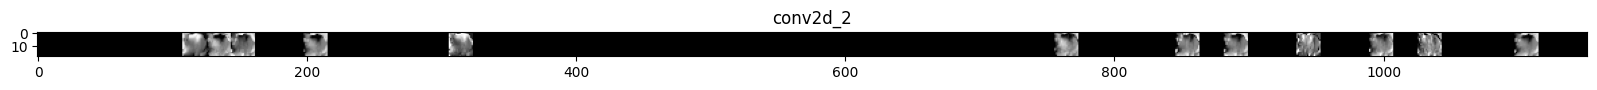

In [20]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
layer_names = [layer.name for layer in cnn.layers]
print(layer_names)
successive_outputs = [layer.output for layer in cnn.layers[1:]]
visualization_model = Model(cnn.input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(160, 160))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (160, 160, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (160, 160, 160, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in cnn.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')